# Homework-2 Question 4: Electricity grid with storage
The town of Hamilton buys its electricity from the Powerco
utility, which charges for electricity on an hourly basis. If less than 50 MWh is used during a given
hour, then the cost is \$100 per MWh. Any excess beyond 50 MWh used during the hour is charged at
the higher rate of \$400 per MWh. The maximum power that Powerco can provide in any given hour is
75 MWh. Here is what the average daily electricity demand looks like for Hamilton during the month
of January

| | | | | | | | | | | | |
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
Hour of day (AM)  | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
Demand (MWh)  | 43 | 40 | 36 | 36 | 35 | 38 | 41 | 46 | 49 | 48 | 47 | 47

| | | | | | | | | | | | |
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
Hour of day (PM) |  1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
Demand (MWh) | 48 | 46 | 45 | 47 | 50 | 63 | 75 | 75 | 72 | 66 | 57 | 50

The mayor of Hamilton is concerned because the high electricity use during evening hours is costing
the city a lot of money. There is also risk of black-outs at around 7pm because the average demand is
dangerously close to Powerco’s 75 MW limit.
To address these issues, the mayor purchased a large battery with a storage capacity of 30 MWh. The
idea is that extra electricity could be purchased early in the day (at the lower rate), stored in the
battery, and used later in the day when demand (and prices) are high.

__ a) How much money can the town of Hamilton save per day thanks to the battery? Assume that
the battery begins the day completely drained. Also, to be safe from possible black-outs, limit
the amount of electricity purchased every hour to a maximum of 65 MWh. __

## Problem Data

In [1]:
n_hours = 24
demand_arr = [43 40 36 36 35 38 41 46 49 48 47 47 48 46 45 47 50 63 75 75 72 66 57 50]
demand = Dict(zip(1:n_hours,demand_arr))

curr_cost = 0
for h in 1:n_hours
    curr_cost += (demand[h]*100)*(demand[h]<=50) + (demand[h]>50)*((demand[h] - 50)*400 + 50*100)
end

println("Currently the town spends \$",curr_cost," daily for its electricty needs")

Currently the town spends $152400 daily for its electricty needs


## Problem Model 

In [2]:
using JuMP

m = Model()

batteryCapacity = 30

# Variable vector for power taken at lower rate of $100 per hour
@variable(m, 0 <= lRatePower[1:n_hours] <= 50)
# Variable vector for power taken at higher rate of $400 per hour
@variable(m, hRatePower[1:n_hours] >= 0)  
# Variable vector for battery charge per hour
@variable(m, battery[1:n_hours+1] >= 0)   

# Constraint to limit the total intake of power to be 65MWh
@constraint(m, [lRatePower[h]+hRatePower[h] for h in 1:n_hours] .<= 65)

# Initial constraint to start battery empty at the start of the day
@constraint(m, battery[1] == 0) 

# Power flow constraint, which means power taken is either used or 
# stored in the battery for the next hour
@constraint(m, [battery[h] + lRatePower[h] + hRatePower[h] - battery[h+1] - demand[h] 
        for h in 1:n_hours] .== 0)

# Constraint for battery capcacity
@constraint(m, [battery[h] for h in 1:n_hours+1] .<= batteryCapacity)

# Objective function to minimize the total power intake.
@objective(m, Min, sum(lRatePower[h]*100 + hRatePower[h]*400 for h in 1:n_hours));

In [3]:
status = solve(m)
println("Status: ",status)
println("After battery of 30MWh the town spends \$",getobjectivevalue(m),
    " daily for its electricty needs")
println("The savings are equal to \$",curr_cost-getobjectivevalue(m))
println()
lRate_a = getvalue(lRatePower)
hRate_a = getvalue(hRatePower)
Battery_a = getvalue(battery)
println("Battery + lRate + hRate = Battery(for next hour) + demand(now) ")
for h in 1:n_hours
    println(Battery_a[h],"\t  ", lRate_a[h],"\t  ", hRate_a[h],"\t=\t",
        Battery_a[h+1],"\t\t \t", demand[h])
end

Status: Optimal
After battery of 30MWh the town spends $143400.0 daily for its electricty needs
The savings are equal to $9000.0

Battery + lRate + hRate = Battery(for next hour) + demand(now) 
0.0	  50.0	  0.0	=	7.0		 	43
7.0	  50.0	  0.0	=	17.0		 	40
17.0	  19.0	  0.0	=	0.0		 	36
0.0	  36.0	  0.0	=	0.0		 	36
0.0	  35.0	  0.0	=	0.0		 	35
0.0	  38.0	  0.0	=	0.0		 	38
0.0	  44.0	  0.0	=	3.0		 	41
3.0	  50.0	  0.0	=	7.0		 	46
7.0	  50.0	  0.0	=	8.0		 	49
8.0	  50.0	  0.0	=	10.0		 	48
10.0	  50.0	  0.0	=	13.0		 	47
13.0	  50.0	  0.0	=	16.0		 	47
16.0	  50.0	  0.0	=	18.0		 	48
18.0	  50.0	  0.0	=	22.0		 	46
22.0	  50.0	  0.0	=	27.0		 	45
27.0	  50.0	  0.0	=	30.0		 	47
30.0	  50.0	  0.0	=	30.0		 	50
30.0	  50.0	  13.0	=	30.0		 	63
30.0	  50.0	  15.0	=	20.0		 	75
20.0	  50.0	  13.0	=	8.0		 	75
8.0	  50.0	  15.0	=	1.0		 	72
1.0	  50.0	  15.0	=	0.0		 	66
0.0	  50.0	  7.0	=	0.0		 	57
0.0	  50.0	  0.0	=	0.0		 	50


__b) How much money would be saved if the battery had an infinite capacity? In this scenario, how
much of the battery’s capacity is actually used?__

To model the case of infinite capacity battery, the upper bound from the battery capacity is removed

In [4]:
batteryCapacity = Inf64
m = Model()
# Variable vector for power taken at lower rate of $100 per hour
@variable(m, 0 <= lRatePower[1:n_hours] <= 50)
# Variable vector for power taken at higher rate of $400 per hour
@variable(m, hRatePower[1:n_hours] >= 0)  
# Variable vector for battery charge per hour
@variable(m, battery[1:n_hours+1] >= 0)   

# Constraint to limit the total intake of power to be 65MWh
@constraint(m, [lRatePower[h]+hRatePower[h] for h in 1:n_hours] .<= 65)
# Initial constraint to start battery empty at the start of the day
@constraint(m, battery[1] == 0) 
# Power flow constraint, which means power taken is either used
# or stored in the battery for the next hour
@constraint(m, [battery[h] + lRatePower[h] + hRatePower[h] - battery[h+1] - demand[h]
        for h in 1:n_hours] .== 0)
# Constraint for battery capcacity
@constraint(m, [battery[h] for h in 1:n_hours+1] .<= batteryCapacity)

# Objective function to minimize the total power intake.
@objective(m, Min, sum(lRatePower[h]*100 + hRatePower[h]*400 for h in 1:n_hours));

status = solve(m)
println("Status: ",status)
println("After battery of ", batteryCapacity," the town spends \$",getobjectivevalue(m),
                " daily for its electricty needs")
println("The savings are equal to \$",curr_cost-getobjectivevalue(m))
println("The maximum capcaity of the battery that is actual used is ",
                maximum(getvalue(battery)))
println()
lRate = getvalue(lRatePower)
hRate = getvalue(hRatePower)
Battery = getvalue(battery)
println("Battery + lRate + hRate = Battery(for next hour) + demand(now) ")
for h in 1:n_hours
    println(Battery[h],"\t  ", lRate[h],"\t  ", hRate[h],"\t=\t",
        Battery[h+1],"\t\t \t", demand[h])
end

Status: Optimal
After battery of Inf the town spends $120000.0 daily for its electricty needs
The savings are equal to $32400.0
The maximum capcaity of the battery that is actual used is 108.0

Battery + lRate + hRate = Battery(for next hour) + demand(now) 
0.0	  50.0	  0.0	=	7.0		 	43
7.0	  50.0	  0.0	=	17.0		 	40
17.0	  50.0	  0.0	=	31.0		 	36
31.0	  50.0	  0.0	=	45.0		 	36
45.0	  50.0	  0.0	=	60.0		 	35
60.0	  50.0	  0.0	=	72.0		 	38
72.0	  50.0	  0.0	=	81.0		 	41
81.0	  50.0	  0.0	=	85.0		 	46
85.0	  50.0	  0.0	=	86.0		 	49
86.0	  50.0	  0.0	=	88.0		 	48
88.0	  50.0	  0.0	=	91.0		 	47
91.0	  50.0	  0.0	=	94.0		 	47
94.0	  50.0	  0.0	=	96.0		 	48
96.0	  50.0	  0.0	=	100.0		 	46
100.0	  50.0	  0.0	=	105.0		 	45
105.0	  50.0	  0.0	=	108.0		 	47
108.0	  50.0	  0.0	=	108.0		 	50
108.0	  50.0	  0.0	=	95.0		 	63
95.0	  50.0	  0.0	=	70.0		 	75
70.0	  50.0	  0.0	=	45.0		 	75
45.0	  50.0	  0.0	=	23.0		 	72
23.0	  50.0	  0.0	=	7.0		 	66
7.0	  50.0	  0.0	=	0.0		 	57
0.0	  50.0	  0.0	=	0.0		 	5

## Plot
__c) Make a plot that shows (i) the typical energy demand vs time of day (ii) the electricity purchased
using the strategy found in part a) vs time of day, and (iii) the battery capacity used as a function
of time (draw all three plots on the same axes).__

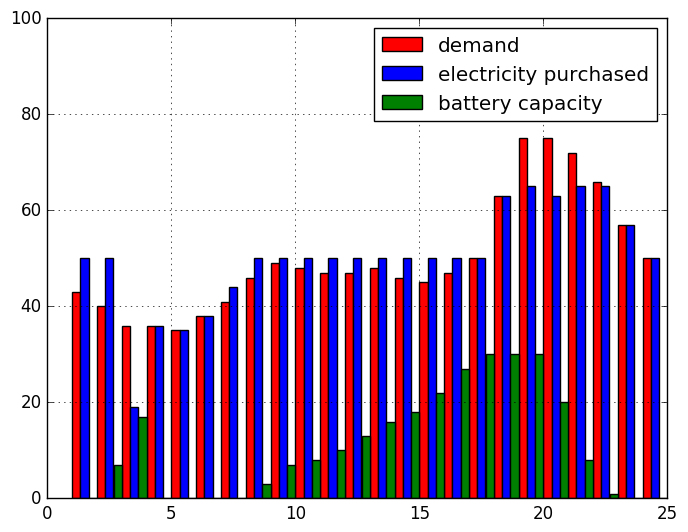

In [7]:
using PyPlot
hours = linspace(1,24,24)
grid("on")
xlim(0,25)
ylim(0,100)
bar(hours,demand_arr',width=0.33,color="red",align="edge", label="demand")
bar(hours.+0.33,lRate_a.+hRate_a,width=0.33,color="blue", align="edge", label="electricity purchased")
bar(hours.+0.67,Battery_a[1:24],width=0.33,color="green", align="edge", label="battery capacity");
legend();

__d) Comment on whether the solutions you found are unique. Are other solutions possible? Why?
Suggest a way of finding another optimal solution.__

The solution consists of all of the possible electricty quantities which can be bought in a particular hour which do not change the total cost incurred through out the day.

The solution found above for part a) is not unique. Since the lower electricity rate applies to any quantity bought below 50MWh, a lot of solutions can exist with the same optimal cost but different combinations of quantity.
For example, at 3AM the demand is 36 and the lower rate electricity bought is 19MWh, If instead the lower rate electricity of 25MWh(a sample value chosen, many other possible) was bought it could have been stored in the battery and used in the next hour.
The total cost remains the same but the solution differs.